In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()

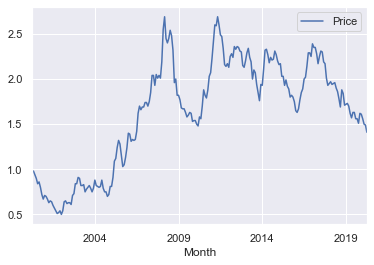

In [5]:
df = pd.read_csv("cofee.csv", parse_dates=True, index_col="Month")
df.plot();

In [28]:
adfuller(df['Price'])

(-1.6667676162438807,
 0.44831097055445085,
 1,
 238,
 {'1%': -3.458128284586202,
  '5%': -2.873761835239286,
  '10%': -2.5732834559706235},
 -459.30443023454916)

Differentiate

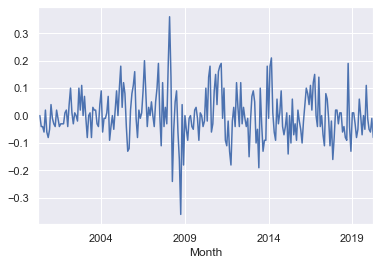

In [6]:
d1 = df['Price'].diff(1)
df['d1'] = d1
df['d1'].plot();
df.dropna(inplace=True)

In [7]:
df['d1'].head()

Month
2000-05-01    0.00
2000-06-01   -0.04
2000-07-01   -0.04
2000-08-01   -0.06
2000-09-01    0.02
Name: d1, dtype: float64

In [29]:
adfuller(df['d1'])

(-11.870157399653603,
 6.532283535383612e-22,
 0,
 239,
 {'1%': -3.458010773719797,
  '5%': -2.8737103617125186,
  '10%': -2.5732559963936206},
 -456.79449671352984)

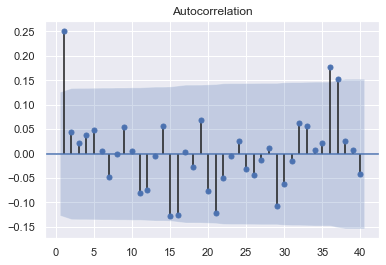

In [8]:
sgt.plot_acf(df['d1'], zero=False, lags=40);

MA model of order around 1

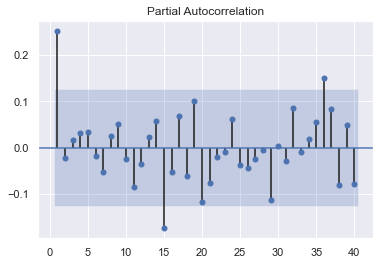

In [9]:
sgt.plot_pacf(df['d1'], zero=False, lags=40);

AR model of order around 1

Both order should be really low.
Let's see what pmdarima will give us.

In [10]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [11]:
auto_arima(df['d1']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 253.339
Date:                Tue, 26 May 2020   AIC                           -500.678
Time:                        16:14:44   BIC                           -490.236
Sample:                             0   HQIC                          -496.471
                                - 240                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.005      0.229      0.819      -0.009       0.012
ar.L1          0.2524      0.053      4.737      0.000       0.148       0.357
sigma2         0.0071      0.001     13.155      0.000       0.006       0.008
===================================================================================
Ljung-Box (Q):                       41.78   Jarque-Bera (JB):                14.81
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
stepwise_fit = auto_arima(df['d1'], start_p=0, start_q=0, max_p=6, max_q=6, d=None, trace=True, stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-487.000, BIC=-480.039, Time=0.039 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-500.678, BIC=-490.236, Time=0.021 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-500.410, BIC=-489.968, Time=0.072 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-488.898, BIC=-485.418, Time=0.015 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=-498.788, BIC=-484.866, Time=0.059 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-498.801, BIC=-484.879, Time=0.048 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-496.719, BIC=-479.316, Time=0.126 seconds
Total fit time: 0.385 seconds


In [13]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 253.339
Date:                Tue, 26 May 2020   AIC                           -500.678
Time:                        16:14:46   BIC                           -490.236
Sample:                             0   HQIC                          -496.471
                                - 240                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.005      0.229      0.819      -0.009       0.012
ar.L1          0.2524      0.053      4.737      0.000       0.148       0.357
sigma2         0.0071      0.001     13.155      0.000       0.006       0.008
===================================================================================
Ljung-Box (Q):                       41.78   Jarque-Bera (JB):                14.81
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [15]:
res=arma_order_select_ic(df['d1'], ic=['aic', 'bic'], trend='nc')
res.aic_min_order

(1, 0)

All cases show that the order should be (1,0)

Lets fit this model to our data

In [16]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [17]:
res2 = ARMA(df['d1'], (1,0)).fit(disp=-1)

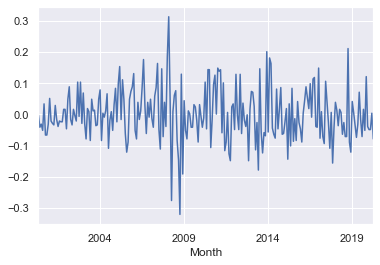

In [18]:
df['res'] = df['d1'] - res2.fittedvalues
df['res'].plot();

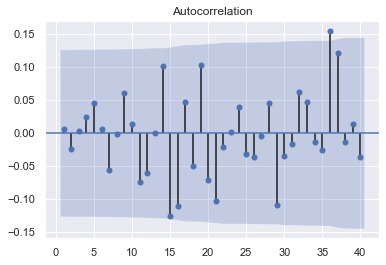

In [24]:
sgt.plot_acf(res2.resid, zero=False, lags=40);

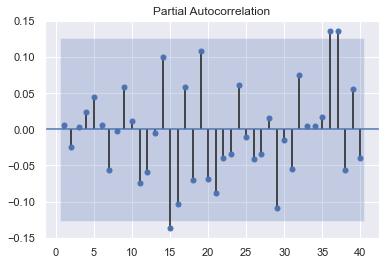

In [26]:
sgt.plot_pacf(res2.resid, zero=False, lags=40);

In [19]:
acorr_ljungbox(res2.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.550461,0.99012


In [20]:
acorr_ljungbox(df.res, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.550461,0.99012


The p value is greater the 0.05, this means this is white noise.

In [23]:
noise = np.random.normal(size=1000)
acorr_ljungbox(noise, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,6.467295,0.774595
